In [ ]:
%pip install torch

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%pip install kaggle

# Dataset Preparation

In [6]:
!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

Dataset URL: https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain
License(s): Attribution 4.0 International (CC BY 4.0)
100%|██████████████████████████████████████| 2.55G/2.55G [05:00<00:00, 8.47MB/s]
100%|██████████████████████████████████████| 2.55G/2.55G [05:00<00:00, 9.10MB/s]


In [7]:
%%capture
!unzip sentinel12-image-pairs-segregated-by-terrain.zip
!rm -rf sentinel12-image-pairs-segregated-by-terrain.zip

In [173]:
import os
import shutil
opt = []
sar = []
root_dir = './v_2'
for dir in os.listdir(root_dir):
  path = os.path.join(root_dir, dir)
  s1, s2  = os.listdir(path)
  if s1 == 's2':
    print(s1)
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s2, file))
  if s1 == 's1':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s2, file))
opt = sorted(opt)
sar = sorted(sar)
print(len(opt), len(sar))


s2
s2
s2
s2
16000 16000


In [21]:
# %pip install torchvision
# %pip install scikit-image
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


# **Denoising The SAR Images**

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from skimage import util
import numpy as np
from PIL import Image

class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(1, n_channels, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, 1, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)



In [175]:
# Dataset Class for Noisy/Clean Image Pairs
class SARImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.sar = clean_images[0]
        self.opt = clean_images[1]
        self.transform = transform

    def __len__(self):
        return len(self.sar)

    def __getitem__(self, idx):
        sar_img = self.sar[idx]
        opt_img = self.opt[idx]
        noisy_img = np.array(Image.open(sar_img).convert('L'))
        img = np.array(Image.open(opt_img).convert('L'))
        if self.transform:
            img = self.transform(img)
            noisy_img = self.transform(noisy_img)
        return noisy_img, img

# Load and preprocess data
images = [sar[:10000], opt[:10000]]
dataset = SARImageDataset(images, transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)


In [87]:
from tqdm import tqdm

# Training the DnCNN Model
denoise_model = DnCNN().to(device)
optimizer = optim.Adam(denoise_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, dataloader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch") as pbar:
            epoch_loss = 0
            for noisy_imgs, clean_imgs in dataloader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                optimizer.zero_grad()
                denoised_imgs = model(noisy_imgs)
                loss = criterion(denoised_imgs, clean_imgs)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                # Update progress bar
                pbar.set_postfix(loss=f"{epoch_loss/(pbar.n+1):.4f}")
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

train(denoise_model, train_loader)


Epoch 1/20 (Training): 100%|██████████| 250/250 [03:29<00:00,  1.19batch/s, loss=0.0498]


Epoch [1/20], Loss: 0.0498


Epoch 2/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0400]


Epoch [2/20], Loss: 0.0400


Epoch 3/20 (Training): 100%|██████████| 250/250 [03:34<00:00,  1.17batch/s, loss=0.0389]


Epoch [3/20], Loss: 0.0389


Epoch 4/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0377]


Epoch [4/20], Loss: 0.0377


Epoch 5/20 (Training): 100%|██████████| 250/250 [03:32<00:00,  1.17batch/s, loss=0.0367]


Epoch [5/20], Loss: 0.0367


Epoch 6/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0360]


Epoch [6/20], Loss: 0.0360


Epoch 7/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0352]


Epoch [7/20], Loss: 0.0352


Epoch 8/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0346]


Epoch [8/20], Loss: 0.0346


Epoch 9/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0340]


Epoch [9/20], Loss: 0.0340


Epoch 10/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0330]


Epoch [10/20], Loss: 0.0330


Epoch 11/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0316]


Epoch [11/20], Loss: 0.0316


Epoch 12/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0309]


Epoch [12/20], Loss: 0.0309


Epoch 13/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0299]


Epoch [13/20], Loss: 0.0299


Epoch 14/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0291]


Epoch [14/20], Loss: 0.0291


Epoch 15/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0289]


Epoch [15/20], Loss: 0.0289


Epoch 16/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0288]


Epoch [16/20], Loss: 0.0288


Epoch 17/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0283]


Epoch [17/20], Loss: 0.0283


Epoch 18/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0277]


Epoch [18/20], Loss: 0.0277


Epoch 19/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0275]


Epoch [19/20], Loss: 0.0275


Epoch 20/20 (Training): 100%|██████████| 250/250 [03:33<00:00,  1.17batch/s, loss=0.0274]

Epoch [20/20], Loss: 0.0274


In [88]:
torch.save(denoise_model, 'dcnn.pth')

In [89]:
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
from tqdm import tqdm

# Evaulating the denoising model
def test_accuracy(model, test_dataloader):
    total_psnr = 0
    total_ssim = 0
    num_images = 0
    model.eval()

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(test_dataloader):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            denoised_imgs = model(noisy_imgs)

            denoised_imgs = denoised_imgs.cpu().numpy()
            clean_imgs = clean_imgs.cpu().numpy()
            # Iterate over the batch
            for i in range(clean_imgs.shape[0]):
                psnr = peak_signal_noise_ratio(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)
                ssim = structural_similarity(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)

                total_psnr += psnr
                total_ssim += ssim
                num_images += 1

    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images

    return avg_psnr, avg_ssim

In [90]:
# Calculate PSNR and SSIM on the test set
avg_psnr, avg_ssim = test_accuracy(denoise_model, test_dataloader)
print(f'Average PSNR: {avg_psnr:.2f} dB')
print(f'Average SSIM: {avg_ssim:.4f}')

100%|██████████| 62/62 [00:21<00:00,  2.84it/s]

Average PSNR: 15.42 dB
Average SSIM: 0.2413


## Denoising with the denoising model

In [176]:
denoise_model = torch.load('dcnn.pth', map_location=device)

In [177]:
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

def prediction(model, sar_images):
    model.eval()
    predictedimages = []
    with torch.no_grad():
        for noisy_imgs in tqdm(sar_images):
            noisy_imgs = np.array(Image.open(noisy_imgs).convert('L'))
            noisy_imgs = transforms.ToTensor()(noisy_imgs)
            noisy_imgs = noisy_imgs.unsqueeze(0).to(device)
            denoised_imgs = model(noisy_imgs)
            img = denoised_imgs.squeeze(0).cpu().numpy()
            img = (img[0] * 255).astype('uint8')
            predictedimages.append(img)
    return predictedimages

gray_images = prediction(denoise_model, sar)


100%|██████████| 16000/16000 [04:38<00:00, 57.36it/s]


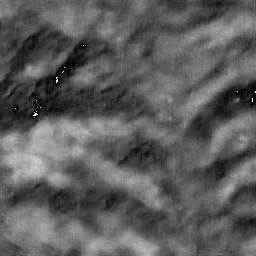

In [189]:
gray_images[1708]
Image.fromarray(gray_images[5739])

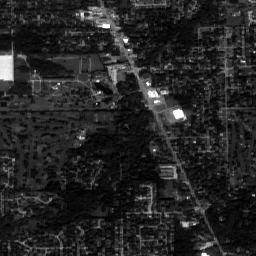

In [185]:
# noise = np.array(Image.open(sar[15060]).convert('L'))+ gray_images[15060]
Image.open(opt[15060]).convert('L')

# DIV2K Dataset


In [8]:
!wget https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip
!wget https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip

--2024-11-17 13:42:39--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 

129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8428103 (8.0M) [application/zip]
Saving to: ‘DIV2K_valid_LR_x8.zip’

DIV2K_valid_LR_x8.z 100%[===================>]   8.04M   118KB/s    in 89s     

2024-11-17 13:44:10 (92.7 KB/s) - ‘DIV2K_valid_LR_x8.zip’ saved [8428103/8428103]

--2024-11-17 13:44:11--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65753171 (63M) [application/zip]
Saving to: ‘DIV2K_train_LR_x8.zip’

DIV2K_train_LR_x8.z 100%[===================>]  62.71M  2.53MB/s    in 24s     

2024-11-17 13:44:35 (2.62 MB/s) - ‘DIV2K_train_LR_x8.zip’ saved [65753171/65753171]



In [ ]:
# !unzip DIV2K_train_LR_x8
# !unzip DIV2K_valid_LR_x8
!rm  DIV2K_train_LR_x8.zip DIV2K_valid_LR_x8.zip

Archive:  DIV2K_train_LR_x8.zip
   creating: DIV2K_train_LR_x8/
  inflating: DIV2K_train_LR_x8/0678x8.png  
  inflating: DIV2K_train_LR_x8/0386x8.png  
  inflating: DIV2K_train_LR_x8/0633x8.png  
  inflating: DIV2K_train_LR_x8/0603x8.png  
  inflating: DIV2K_train_LR_x8/0110x8.png  
  inflating: DIV2K_train_LR_x8/0725x8.png  
  inflating: DIV2K_train_LR_x8/0445x8.png  
  inflating: DIV2K_train_LR_x8/0210x8.png  
  inflating: DIV2K_train_LR_x8/0599x8.png  
  inflating: DIV2K_train_LR_x8/0732x8.png  
  inflating: DIV2K_train_LR_x8/0283x8.png  
  inflating: DIV2K_train_LR_x8/0122x8.png  
  inflating: DIV2K_train_LR_x8/0021x8.png  
  inflating: DIV2K_train_LR_x8/0250x8.png  
  inflating: DIV2K_train_LR_x8/0782x8.png  
  inflating: DIV2K_train_LR_x8/0357x8.png  
  inflating: DIV2K_train_LR_x8/0586x8.png  
  inflating: DIV2K_train_LR_x8/0641x8.png  
  inflating: DIV2K_train_LR_x8/0239x8.png  
  inflating: DIV2K_train_LR_x8/0575x8.png  
  inflating: DIV2K_train_LR_x8/0480x8.png  
  inflating:

In [22]:
import os
train_img = os.listdir('DIV2K_train_LR_x8')
test_img = os.listdir('DIV2K_valid_LR_x8')

In [23]:
train_img = ['DIV2K_train_LR_x8/'+path for path in train_img]
test_img = ['DIV2K_valid_LR_x8/'+path for path in test_img]

data = train_img+test_img
data[:5]

['DIV2K_train_LR_x8/0230x8.png',
 'DIV2K_train_LR_x8/0126x8.png',
 'DIV2K_train_LR_x8/0064x8.png',
 'DIV2K_train_LR_x8/0075x8.png',
 'DIV2K_train_LR_x8/0296x8.png']

# FLICKR30K Dataset

In [58]:
from datasets import load_dataset
ds = load_dataset("nlphuji/flickr30k")

In [65]:
flick_data = ds.select_columns('image')

In [72]:
flick_data['test'][:2]['image']

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374>]

# **Implementing Colorization Model**

In [6]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt



## Preparing dataset for colorization model

In [7]:
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

def rgb_to_lab(img):

    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)
    L_channel = img_lab[[0], ...]
    ab_channels = img_lab[[1, 2], ...]
    # scale between -1 to 1
    L_channel = 2 * (L_channel - (0)) / (100 - (0)) - 1
    ab_channels = 2 * (ab_channels - (-128)) / (127 - (-128)) - 1

    return L_channel, ab_channels

In [8]:
def create_patches(img, patch_size=224):
    patches = []
    h, w = img.shape[1:]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)

    return patches

In [193]:
class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None, patch_size=224):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.color_dir)

    def __getitem__(self, idx):

        gray_img = self.grayscale_dir[idx]
        color_img = np.array(Image.open(self.color_dir[idx]))
        # color_img = np.array(self.color_dir[idx]) # for flickr dataset

        # resize image to 224
        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        # Convert to Lab color space
        gray_L, gray_ab = rgb_to_lab(cv2.merge((gray_img, gray_img, gray_img)))
        L_channel, ab_channels = rgb_to_lab(color_img)

        # # convert gray in range of -1 to 1
        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)


        return gray_L, ab_channels


In [196]:
dataset = ColorizationDataset(gray_images[:6000], opt[:6000])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)




In [197]:
# Load a batch and print the shapes of the patches
for L_patches, ab_patches in train_loader:
    print(f"L_patches shape: {L_patches.shape}")
    print(f"ab_patches shape: {ab_patches.shape}")
    print(L_patches[1])
    break

L_patches shape: torch.Size([8, 1, 224, 224])
ab_patches shape: torch.Size([8, 2, 224, 224])
tensor([[[-0.4937, -0.2603, -0.3109,  ..., -0.2019, -0.2603, -0.1854],
         [-0.3536, -0.2940, -0.2855,  ..., -0.2185, -0.2352, -0.2019],
         [-0.3279, -0.3024, -0.2687,  ..., -0.2185, -0.1771, -0.1362],
         ...,
         [-0.2855, -0.2102, -0.2019,  ..., -0.4230, -0.3881, -0.3795],
         [-0.2019, -0.1607, -0.2435,  ..., -0.3881, -0.3968, -0.4847],
         [-0.3968, -0.4055, -0.2771,  ..., -0.3795, -0.4405, -0.4142]]])


## Implementing the Encoder

In [199]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, DenseNet121_Weights

class EnsembleEncoder(nn.Module):
    def __init__(self):
        super(EnsembleEncoder, self).__init__()

        # Load pre-trained ResNet50 and DenseNet121
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # self.densenet121 = nn.Sequential(*list(self.densenet121.children())[:-1])
        self.densenet121.classifier = nn.Identity()


        # Custom layers for fusion
        self.conv1x1_resnet50 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(2048, 1024, kernel_size=1)
        ])

        self.conv1x1_densenet121 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(1024, 1024, kernel_size=1)
        ])

        self.fusion_blocks = nn.ModuleList([
            self.fusion_block(256, 256),
            self.fusion_block(512, 512),
            self.fusion_block(1024, 1024),
            self.fusion_block(2048, 1024)
        ])

    # Fusion block
    def fusion_block(self, in_channels_resnet, in_channels_densenet):
        return nn.Sequential(
            nn.Conv2d(in_channels_resnet + in_channels_densenet, in_channels_resnet, kernel_size=1),
            nn.BatchNorm2d(in_channels_resnet),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through ResNet50
        resnet_features = []
        resnet_input = x
        for i, layer in enumerate(self.resnet50.children()):
            resnet_input = layer(resnet_input)
            if i in [4, 5, 6, 7]:  # Extract features after specific layers
                resnet_features.append(resnet_input)

        # Forward pass through DenseNet121
        densenet_features = []
        idx = 0
        densenet_input = x
        for i, layer in enumerate(self.densenet121.features):
            densenet_input = layer(densenet_input)
            if i in [ 4, 6, 8, 11]:
                densenet_features.append(densenet_input)
                idx += 1


        fused_features = []
        for i in range(4):
            fused = torch.cat((resnet_features[i], densenet_features[i]), dim=1)
            fused = self.fusion_blocks[i](fused)
            fused_features.append(fused)

        return fused_features


In [200]:
# input data
L_patches = torch.randn(1, 3, 224, 224)
encoder = EnsembleEncoder()
fused, resnet, densenet = encoder(L_patches)

for i in range(4):
    print(fused[i].shape)
    # print(resnet[i].shape)
    # print(densenet[i].shape)



ValueError: too many values to unpack (expected 3)

## Implementing the Decoder

In [230]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        def repeat_blocks(input_size): 
            return nn.Sequential( 
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size), nn.ReLU(), 
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1), 
                nn.BatchNorm2d(input_size), nn.ReLU(), 
                nn.Conv2d(input_size, input_size, kernel_size=3,padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1), 
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                nn.Conv2d(input_size, input_size, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(input_size),nn.ReLU(),
                )

        # Decoder block 1: Takes input from Fusion Block 4
        self.decode1 = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            # repeat_blocks(1024),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 7x7 -> 14x14
        )

        # Decoder block 2: Takes input from Decoder Block 1 + Fusion Block 3 (512 + 512 channels)
        self.decode2 = nn.Sequential(
            nn.Conv2d(1024 + 1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # repeat_blocks(512),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14 -> 28x28
        )

        # Decoder block 3: Takes input from Decoder Block 2 + Fusion Block 2 (256 + 256 channels)
        self.decode3 = nn.Sequential(
            nn.Conv2d(512 + 512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # repeat_blocks(256),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28 -> 56x56
        )

        # Decoder block 4: Takes input from Decoder Block 3 + Fusion Block 1 (128 + 128 channels)
        self.decode4 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # repeat_blocks(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 56x56 -> 112x112
        )

        # Final decoder block: Reduce to 2 channels (ab channels)
        self.decode5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # repeat_blocks(64),
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 112x112 -> 224x224
        )

    def forward(self, features_7x7, features_14x14, features_28x28, features_56x56):
        x = self.decode1(features_7x7)
        x = torch.cat([x, features_14x14], dim=1)
        x = self.decode2(x)

        x = torch.cat([x, features_28x28], dim=1)
        x = self.decode3(x)

        x = torch.cat([x, features_56x56], dim=1)
        x = self.decode4(x)

        output = self.decode5(x)

        return output


## Checking our model

In [231]:
import torch
import torch.nn as nn

class ColorizationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ColorizationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        features_56x56, features_28x28, features_14x14, features_7x7 = self.encoder(x)
        # print(features_7x7)

        output = self.decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        return output

encoder = EnsembleEncoder()
decoder = Decoder()

model = ColorizationModel(encoder, decoder)

# input data
L_patches = torch.randn(1, 3, 224, 224)

output = model(L_patches)

print("Output shape:", output.shape)  # output shape should be [1, 2, 224, 224]


Output shape: torch.Size([1, 2, 224, 224])


In [ ]:
def visualize_feature_maps(encoder, input_image):
    # Get features from the encoder
    resnet_features = encoder(input_image)  # Pass input to get features
    # resnet_features = encoder.resnet_features
    # densenet_features = encoder.densenet_features

    # Function to plot feature maps for a single layer
    def plot_feature_maps_layer(features, title):
        num_features = features.shape[1]
        num_cols = 8  # Number of columns in the grid
        num_rows = (num_features + num_cols - 1) // num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
        fig.suptitle(title, fontsize=16)

        for i in range(num_features):
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.imshow(features[0, i].cpu().detach().numpy(), cmap='gray')
            ax.axis('off')

        # Hide any unused subplots
        for i in range(num_features, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.axis('off')

        plt.show()

    # Visualize feature maps for each fusion block
    for i in range(1):
        plot_feature_maps_layer(resnet_features[3], f"ResNet50 - Fusion Block {i+1}")
        # plot_feature_maps_layer(densenet_features[i], f"DenseNet121 - Fusion Block {i+1}")

In [ ]:
for L_batch, real_ab in train_loader:
    L_batch = L_batch.repeat(1,3,1,1)
    print(L_batch.shape)
    # features = encoder(L_batch)
    # print(features[0].shape)
    # print(features[1].shape)
    # print(features[2].shape)
    # print(features[3].shape)
    visualize_feature_maps(encoder, L_batch)
    break

In [ ]:
%pip install pytorch-msssim

In [44]:
from pytorch_msssim import ssim

class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def forward(self, pred, target):
        return 1 - ssim(pred, target, data_range=2.0, size_average=True)


## Training the model

In [232]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder and decoder
encoder = EnsembleEncoder().to(device)
decoder = Decoder().to(device)

# Freeze the encoder parameters as they are pre-trained
for param in encoder.parameters():
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.MSELoss()
# criterion  = SSIMLoss().to(device)
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    encoder.eval()  # Keep encoder in evaluation mode
    decoder.train()  # Train only the decoder
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")
    for i, (L_batch, ab_batch) in enumerate(train_bar):
        L, ab = L_batch.to(device), ab_batch.to(device)
        L = L.repeat(1, 3, 1, 1)  # Replicate grayscale to 3 channels for input

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L)
        output = decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        # Compute loss
        loss = criterion(output, ab)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

        # Update progress bar
        train_bar.set_postfix(loss=f"{running_loss/(i+1):.4f}")

    # Validation phase
    decoder.eval()  # Set decoder to evaluation mode
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
    with torch.no_grad():
        for i, (L_batch, ab_batch) in enumerate(val_bar):
            L, ab = L_batch.to(device), ab_batch.to(device)
            L = L.repeat(1, 3, 1, 1)  # Replicate grayscale to 3 channels

            # Forward pass
            features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L)
            output = decoder(features_7x7, features_14x14, features_28x28, features_56x56)

            # Compute validation loss
            loss = criterion(output, ab)
            val_loss += loss.item()

            val_bar.set_postfix(loss=f"{val_loss/(i+1):.4f}")

    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(decoder.state_dict(), 'decoder_1.pth')
        print(f"Model saved with validation loss: {best_val_loss:.4f}")

    # Step the scheduler
    scheduler.step(avg_val_loss)

print("Training complete.")


Epoch 1/10 (Validation): 100%|██████████| 120/120 [00:11<00:00, 10.75it/s, loss=0.0105]


Epoch 1/10, Training Loss: 0.0278, Validation Loss: 0.0105
Model saved with validation loss: 0.0105


Epoch 2/10 (Validation): 100%|██████████| 120/120 [00:11<00:00, 10.72it/s, loss=0.0060]


Epoch 2/10, Training Loss: 0.0113, Validation Loss: 0.0060
Model saved with validation loss: 0.0060


Epoch 3/10 (Validation): 100%|██████████| 120/120 [00:11<00:00, 10.63it/s, loss=0.0104]


Epoch 3/10, Training Loss: 0.0111, Validation Loss: 0.0104


Epoch 4/10 (Validation): 100%|██████████| 120/120 [00:11<00:00, 10.69it/s, loss=0.0082]


Epoch 4/10, Training Loss: 0.0098, Validation Loss: 0.0082


Epoch 5/10 (Validation): 100%|██████████| 120/120 [00:11<00:00, 10.59it/s, loss=0.0388]


Epoch 5/10, Training Loss: 0.0129, Validation Loss: 0.0388


Epoch 6/10 (Validation): 100%|██████████| 120/120 [00:14<00:00,  8.06it/s, loss=0.0063]


Epoch 6/10, Training Loss: 0.0074, Validation Loss: 0.0063


Epoch 7/10 (Validation): 100%|██████████| 120/120 [00:10<00:00, 11.50it/s, loss=0.0057]


Epoch 7/10, Training Loss: 0.0054, Validation Loss: 0.0057
Model saved with validation loss: 0.0057


Epoch 8/10 (Validation): 100%|██████████| 120/120 [00:10<00:00, 11.31it/s, loss=0.0048]


Epoch 8/10, Training Loss: 0.0053, Validation Loss: 0.0048
Model saved with validation loss: 0.0048


Epoch 9/10 (Validation): 100%|██████████| 120/120 [00:10<00:00, 11.32it/s, loss=0.0045]


Epoch 9/10, Training Loss: 0.0050, Validation Loss: 0.0045
Model saved with validation loss: 0.0045


Epoch 10/10 (Validation): 100%|██████████| 120/120 [00:10<00:00, 11.35it/s, loss=0.0044]


Epoch 10/10, Training Loss: 0.0049, Validation Loss: 0.0044
Model saved with validation loss: 0.0044
Training complete.


In [233]:
torch.cuda.empty_cache()

## Preparing for prediction

In [205]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab

class ColorizationDatasetNew(Dataset):
    def __init__(self, gray_img, opt_image, transform=None):
        self.gray_image = gray_img
        self.opt_image = opt_image
        self.transform = transform

    def __len__(self):
        return len(self.gray_image)

    def __getitem__(self, idx):
        gray_img = self.gray_image[idx]
        color_img = np.array(Image.open(self.opt_image[idx]))

        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        gray_L, gray_ab = rgb_to_lab(cv2.merge([gray_img, gray_img, gray_img]))
        L_channel, ab_channels = rgb_to_lab(color_img)

        gray_img = gray_img / 2.55 # [0,100]
        gray_img = ((gray_img - (0)) / (100 - (0))) * 2 - 1 # [-1, 1]
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)

        return gray_L, L_channel, ab_channels

# Create the test dataset for prediction
dataset_new = ColorizationDatasetNew(gray_images[10000:], opt[10000:])

test_set_new = DataLoader(dataset_new, batch_size=32, shuffle=False, num_workers=2)

In [206]:
for L,real_L, ab in test_set_new:
    print(real_L.shape)
    print(L.shape)
    print(ab.shape)
    print(L[0][0])
    break

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])
tensor([[-0.3795, -0.2019, -0.2268,  ..., -0.1036, -0.1362, -0.1280],
        [-0.1854, -0.1854, -0.2185,  ..., -0.1117, -0.1199, -0.1525],
        [-0.2185, -0.2771, -0.2352,  ..., -0.1607, -0.1362, -0.0955],
        ...,
        [-0.3536, -0.3795, -0.3536,  ..., -0.2019, -0.2519, -0.3365],
        [-0.4581, -0.3536, -0.3708,  ..., -0.2435, -0.2519, -0.3194],
        [-0.3795, -0.3536, -0.2855,  ..., -0.2185, -0.2940, -0.1689]])


# Inference

In [234]:
# Get a batch from the test loader
dataiter = iter(test_set_new)
L_batch, real_L, ab_batch = next(dataiter)
# L_batch,real_L, ab_batch = next(dataiter)
# L_batch,real_L, ab_batch = next(dataiter)
L_batch, real_L, ab_batch = L_batch.to(device),real_L.to(device), ab_batch.to(device)
L_batch = L_batch.repeat(1, 3, 1, 1)

encoder.eval()
decoder.eval()
with torch.no_grad():
    features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L_batch)

    predicted_ab = decoder(features_7x7, features_14x14, features_28x28, features_56x56)


In [235]:
# L_batch = L_batch.unsqueeze(1)
np.max((L_batch[0].cpu().numpy() +1) * 0.5 *100)

np.float32(49.238987)

In [236]:
L_batch = L_batch[:, 0, :, :]
L_batch = L_batch.unsqueeze(1)

L_batch = (L_batch + 1) * 0.5 * 100
real_L = (real_L + 1) * 0.5 * 100
predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

# Combine L and ab channels
predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
real_lab = torch.cat([L_batch, ab_batch], dim=1)
actual_lab = torch.cat([real_L, ab_batch], dim=1)
mixed_lab = torch.cat([real_L, predicted_ab], dim=1)

predicted_lab = predicted_lab.cpu().numpy()
real_lab = real_lab.cpu().numpy()
actual_lab = actual_lab.cpu().numpy()
mixed_lab = mixed_lab.cpu().numpy()

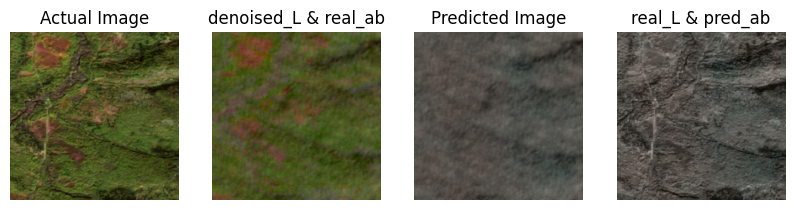

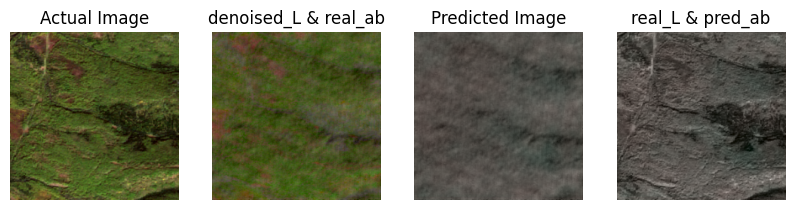

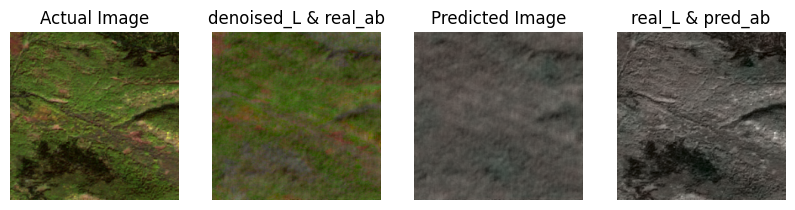

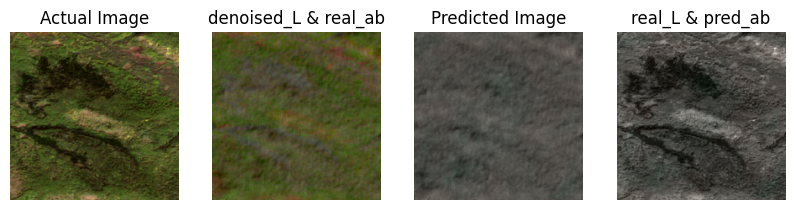

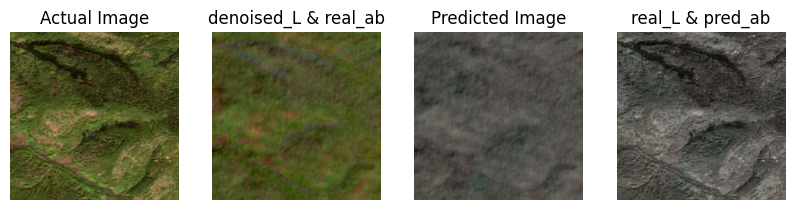

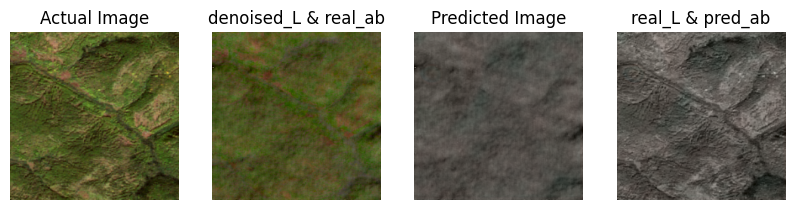

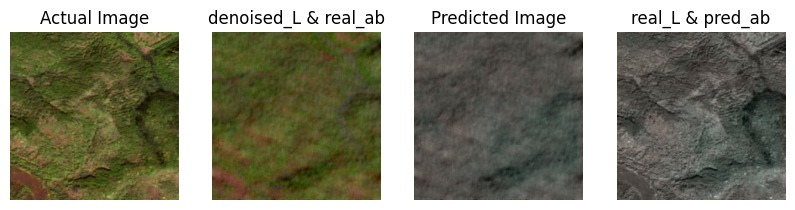

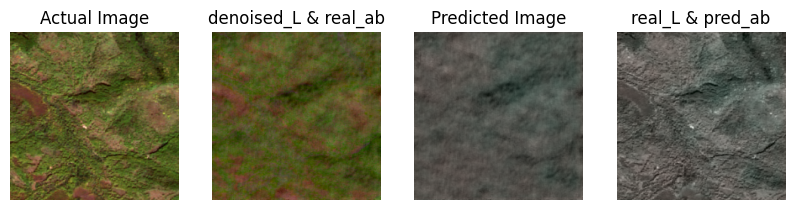

In [237]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import cv2


# Iterate over the batch
for i in range(8):

    lab_image = predicted_lab[i]
    real_img = real_lab[i]
    actual_img = actual_lab[i]
    mixed_img = mixed_lab[i]

    # Transpose to (height, width, 3) for skimage
    lab_image = lab_image.transpose(1, 2, 0).astype(np.float64)
    real_img = real_img.transpose(1, 2, 0).astype(np.float64)
    actual_img = actual_img.transpose(1, 2, 0).astype(np.float64)
    mixed_img = mixed_img.transpose(1, 2, 0).astype(np.float64)

    # Convert Lab to RGB using skimage.color.lab2rgb
    rgb_image = lab2rgb(lab_image)
    real_rgb = lab2rgb(real_img)
    actual_rgb = lab2rgb(actual_img)
    mixed_rgb = lab2rgb(mixed_img)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(actual_rgb)
    plt.axis('off')
    plt.title('Actual Image')
    plt.subplot(1, 4, 2)
    plt.imshow(real_rgb)
    plt.axis('off')
    plt.title('denoised_L & real_ab')
    plt.subplot(1, 4, 3)
    plt.imshow(rgb_image)
    plt.title('Predicted Image')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(mixed_rgb)
    plt.title('real_L & pred_ab')
    plt.axis('off')
    plt.show()

## Evaulting the Model

In [219]:
def prediction(model, test_loader):
    encoder.eval()
    model.eval()
    original_images = []
    predicted_images = []

    for L_batch, real_L, ab_batch in tqdm(test_loader):
        L_batch,real_L, ab_batch = L_batch.to(device), real_L.to(device), ab_batch.to(device)
        input = L_batch.repeat(1, 3, 1, 1)

        with torch.no_grad():
            features_56x56, features_28x28, features_14x14, features_7x7 = encoder(input)

            predicted_ab = model(features_7x7, features_14x14, features_28x28, features_56x56)
            # predicted_ab = model(input)

        L_batch = (L_batch + 1) * 0.5 * 100
        real_L = (real_L + 1) * 0.5 * 100
        predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
        ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

        # Combine L and ab channels
        predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
        actual_lab = torch.cat([real_L, ab_batch], dim=1)

        predicted_lab = predicted_lab.cpu().numpy()
        actual_lab = actual_lab.cpu().numpy()

        predicted_images.extend(predicted_lab)
        original_images.extend(actual_lab)

    return original_images, predicted_images

original_images, predicted_images = prediction(decoder, test_set_new)

100%|██████████| 188/188 [00:46<00:00,  4.00it/s]


In [220]:
original_images[0].shape

(3, 224, 224)

In [221]:
original_img = lab2rgb(original_images[800].transpose(1, 2, 0).astype(np.float64))
predicted_img = lab2rgb(predicted_images[800].transpose(1, 2, 0).astype(np.float64))
# original_img = original_img.astype(np.float64) / 255.0
# predicted_img = predicted_img.astype(np.float64) / 255.0
max_value = np.max(predicted_img)
min_value = np.min(predicted_img)
print(max_value)
print(min_value)

0.7460554528521025
0.04954893518617096


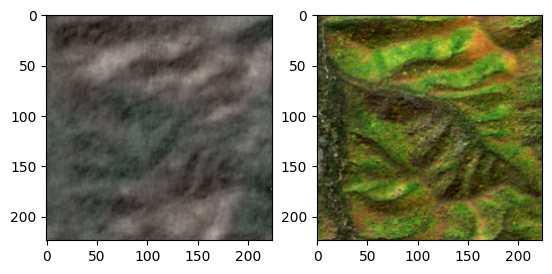

In [222]:

# original_img = (original_img - min_value) / (max_value - min_value)
plt.subplot(1, 2, 1)
plt.imshow(predicted_img)
plt.subplot(1, 2, 2)
plt.imshow(original_img)
plt.show()

In [223]:
import warnings

warnings.filterwarnings('ignore')

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import lab2rgb
import numpy as np

def evaluate_model(original_images, predicted_images):

    total_ssim = 0.0
    total_psnr = 0.0
    total_samples = 0
    for original_img, predicted_img in tqdm(zip(original_images, predicted_images)):
        original_img = lab2rgb(original_img.transpose(1, 2, 0))
        predicted_img = lab2rgb(predicted_img.transpose(1, 2, 0))

        ssim_value = ssim(original_img, predicted_img, multichannel=True, channel_axis=2, data_range=1.0)
        psnr_value = psnr(original_img, predicted_img, data_range=1.0)
        total_ssim += ssim_value
        total_psnr += psnr_value
        total_samples += 1

    average_ssim = total_ssim / total_samples
    average_psnr = total_psnr / total_samples

    return average_ssim, average_psnr

ssim_value, psnr_value = evaluate_model(original_images, predicted_images)
print(f"Average SSIM: {ssim_value:.4f}")
print(f"Average PSNR: {psnr_value:.4f}")



6000it [01:14, 80.72it/s]

Average SSIM: 0.1562
Average PSNR: 12.7617
